# Load and transform datasets

* Import data
* Transform event_id to string for later encoding
* Transform start column to datetime

In [88]:
%%time
%matplotlib inline
import pandas as pd
import sys
sys.path.append('../tools')

probs = pd.read_parquet('../data/probs.parquet', engine='pyarrow')
normals = pd.read_parquet('../data/normals.parquet', engine='pyarrow')

probs.event_id = probs.event_id.astype('str')
normals.event_id = normals.event_id.astype('str')

# Convert unix time to timestamp
probs.start = probs.start.astype('M8[s]')
normals.start = normals.start.astype('M8[s]')

CPU times: user 19.6 s, sys: 312 ms, total: 19.9 s
Wall time: 19.5 s


Fix identifiers - the same identity can have a regular day and a bad day. We will join the datasets and thus need the IDs to be unique

In [89]:
pident = set(probs.ident.unique())
nident = set(normals.ident.unique())

probs_coding = {}
norms_coding = {}
i = 0
for ident in list(pident): 
    probs_coding[ident] = i
    i += 1

for ident in list(nident):
    norms_coding[ident] = i
    i += 1
    
probs.ident = probs.ident.apply(lambda x: probs_coding[x])
normals.ident = normals.ident.apply(lambda x: norms_coding[x])

In [90]:
ident_class_dict = probs.set_index('ident')['probs'].to_dict()
ident_class_dict.update(normals.set_index('ident')['probs'].to_dict())

## What's in the data

In [91]:
for col in [x for x in probs.columns if x != 'start']:
    print('\n========={}========='.format(col))
    n_values = len(probs[col].unique())
    m_common = probs[col].value_counts()[:5].index
    m_common = ', '.join(list(map(str, m_common)))
    print('Different values: {}'.format(n_values))
    print('5 most common: {}'.format(m_common))    


=========ident=========
Different values: 500
5 most common: 0, 44, 3, 241, 115

=========event_result=========
Different values: 4
5 most common: SUCCESS, REJECT, ABORT, IGNORE

=========cause_code=========
Different values: 27
5 most common: NOCAUSECODE, UNKNOWN_CAUSE_CODE_PROT_TYPE_0, SUCCESSFUL_HANDOVER, REACTIVATION_REQUIRED, REGULAR_DEACTIVATION

=========sub_cause_code=========
Different values: 67
5 most common: SUCCESS, NO_VALUE, QOS_CHANGED_BY_GGSN_DURING_RAU_OR_SGSN_OR_BSS_MODIFICATION_PROCEDURE, ALL_PACKET_ORIENTED_SERVICES_BARRED, TIMEOUT_PAGING

=========mecontext=========
Different values: 2
5 most common: EMME1, EMME2

=========TAC=========
Different values: 360
5 most common: 35812507, 86099803, 86675802, 86813502, 35439508

=========event_id=========
Different values: 13
5 most common: 13, 2, 7, 15, 8

=========probs=========
Different values: 1
5 most common: True


# Plot the data

## Value counts

Calculate value counts for all columns for both datasets. Plot most common columns.  
You are welcome to plot other columns as well but on a large screen, this is unwise.

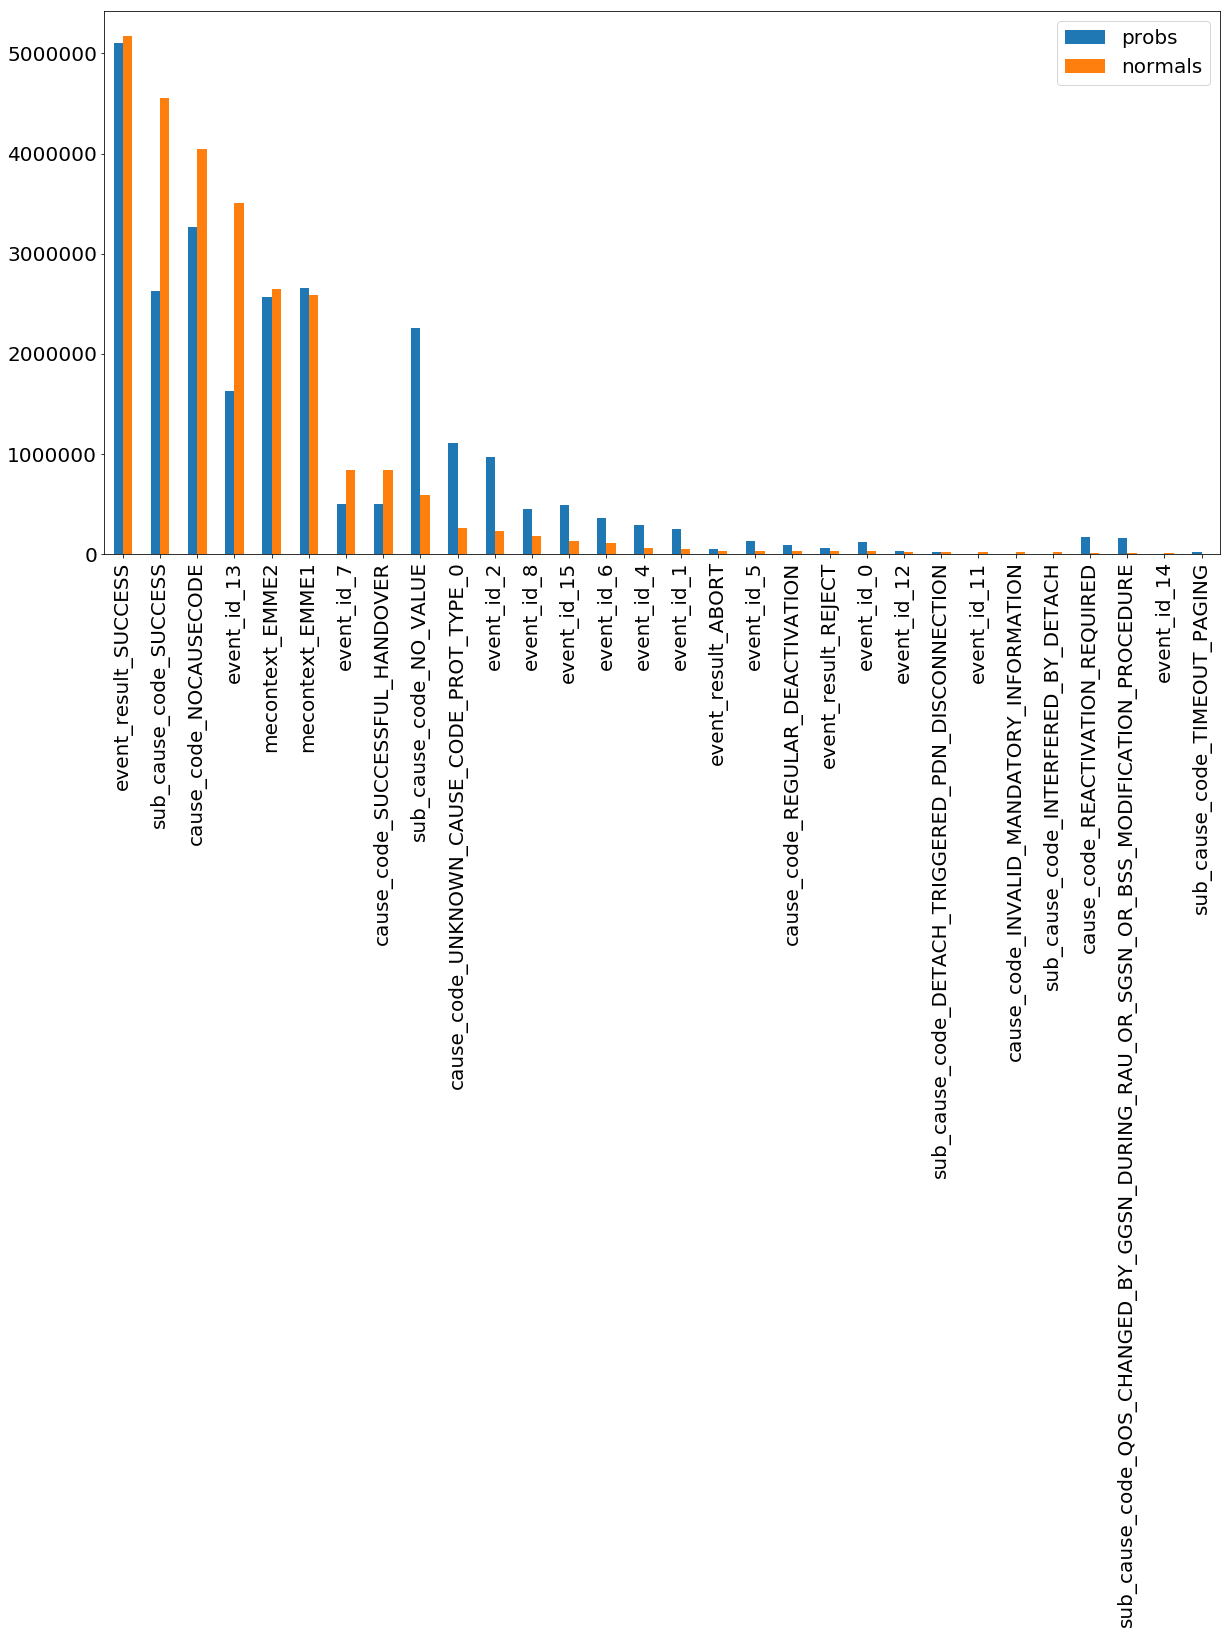

CPU times: user 6.63 s, sys: 0 ns, total: 6.63 s
Wall time: 6.5 s


In [92]:
%%time
import matplotlib.pyplot as plt 
from tools import make_stats
import matplotlib
matplotlib.rcParams.update({'font.size': 20})


raw_stats = [make_stats(probs), make_stats(normals)]

ratio = probs.shape[0] / normals.shape[0]
b_ratio = normals.shape[0] / probs.shape[0]

stats = pd.concat(raw_stats[0].align(raw_stats[1], join='right'), axis=1).fillna(0)
stats.columns = ['probs', 'normals']
stats.probs = stats.probs / ratio 

most_common = stats.sort_values('normals', ascending=False).index.values[:30]
stats.loc[most_common].plot.bar(figsize=[20,10])
plt.show()

## User profiles

Plot the profiles over the course of the day for categorical columns.  
Here we plot them both by:
  1. unique values in a half hour slot 
  2. total values in a half hour slot
  
First, by unique values:

CPU times: user 15.2 s, sys: 0 ns, total: 15.2 s
Wall time: 15 s


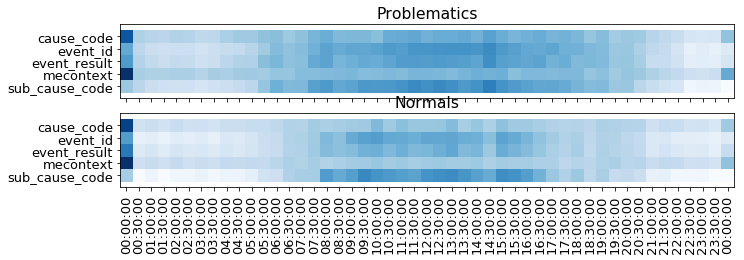

In [93]:
%%time 
##########################
# probs average plot
##########################
import datetime as dt
import numpy as np
from tools import plot_hmap, gen_day_splits
import tools
matplotlib.rcParams.update({'font.size': 13})

# Turn off warnings
pd.options.mode.chained_assignment = None  # default='warn'

categorical_columns = ['cause_code', 'event_id', 'event_result', 'mecontext', 'sub_cause_code']

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=[11,3])
ident_to_plot = np.random.choice(probs.ident.unique(), 100)
df_avg = [plot_hmap(probs, ident) for ident in ident_to_plot]
df_avg = sum([x.values for x in df_avg]) / len(df_avg)
df_avg = df_avg / df_avg.sum(axis=0)
ax1.imshow(df_avg.T, cmap='Blues')
ax1.set_title('Problematics')

ident_to_plot = np.random.choice(normals.ident.unique(), 100)
df_avg = [plot_hmap(normals, ident) for ident in ident_to_plot]
df_avg = sum([x.values for x in df_avg]) / len(df_avg)
df_avg = df_avg / df_avg.sum(axis=0)
ax2.imshow(df_avg.T, cmap='Blues')
ax2.set_title('Normals')

xticks = gen_day_splits(30)
plt.yticks(range(len(categorical_columns)), categorical_columns)
plt.xticks(range(len(xticks)), xticks, rotation=90);

.. Then by total values: 

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 14.1 s


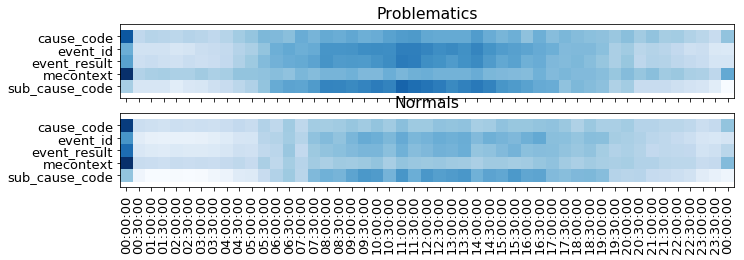

In [94]:
%%time 

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=[11,3])
ident_to_plot = np.random.choice(probs.ident.unique(), 100)
df_avg = [plot_hmap(probs, ident, False) for ident in ident_to_plot]
df_avg = sum([x.values for x in df_avg]) / len(df_avg)
df_avg = df_avg / df_avg.sum(axis=0)
ax1.imshow(df_avg.T, cmap='Blues')
ax1.set_title('Problematics')

ident_to_plot = np.random.choice(normals.ident.unique(), 100)
df_avg = [plot_hmap(normals, ident, False) for ident in ident_to_plot]
df_avg = sum([x.values for x in df_avg]) / len(df_avg)
df_avg = df_avg / df_avg.sum(axis=0)
ax2.imshow(df_avg.T, cmap='Blues')
ax2.set_title('Normals')

xticks = gen_day_splits(30)
plt.yticks(range(len(categorical_columns)), categorical_columns)
plt.xticks(range(len(xticks)), xticks, rotation=90);

# Transform the data

## Add device data

Join device info table to the data. Currently we use just the network type and device type, but more could be used in case of interest.  
**network type** - The network type the device is certified for.  
**device type** - Whether the device is a smartphone or a tablet, etc.

In [ ]:
%%time
phone_models = pd.read_msgpack('../data/phone_models.msgpack')

device_info = phone_models.loc[:,['TAC', 'seadme_tyyp', 'phone_type']]
device_info.rename(columns={'seadme_tyyp': 'network_type'}, inplace=True)

def add_device_info(df):
    df = df.merge(device_info, on='TAC')
    df.drop(labels=['TAC'], axis=1, inplace=True)
    return df

normals = add_device_info(normals)
probs = add_device_info(probs)

CPU times: user 4.15 s, sys: 0 ns, total: 4.15 s
Wall time: 4.07 s


## Make timedelta

Turn the time into a timedelta since previous record. This is the longest running cell and takes about a minute or two.

In [ ]:
%%time
def group_timedelta(group):
    group.sort_values('start', inplace=True)
    group['timedelta'] = group.start - group.start.shift()
    group.timedelta.fillna(0, inplace=True)
    return group

def make_timedelta(df):
    df = df.groupby('ident', as_index=False).apply(group_timedelta)
    df = df.reset_index().iloc[:,2:]
    df.timedelta = df.timedelta.dt.seconds
    return df

normals = make_timedelta(normals)
probs = make_timedelta(probs)

## Make DF using one hot encoding

Encodes all features using one hot encoding. Also the timedelta is changed into a categorical feature by using binning.  
The number of features that can be used is directly tied to the amount of RAM available on the system.

In [ ]:
%%time 
import gc

# cats = ['event_result', 'cause_code', 'sub_cause_code', 'mecontext', 'event_id', 'network_type', 'phone_type']
cats = ['event_result', 'cause_code', 'event_id', 'timedelta']
non_cats = ['ident', 'probs']
def encode_columns(df):
    return pd.concat([df[non_cats], pd.get_dummies(df[cats])], axis=1)
     
df = pd.concat([normals, probs])
df.timedelta = pd.cut(df.timedelta, [0,1,5,60,1800,3600,3600*24], right=False)
df = encode_columns(df)

probs = df.loc[df.probs]
normals = df.loc[~df.probs]

probs.to_parquet('../data/probs_interm.parquet')
normals.to_parquet('../data/norms_interm.parquet')

del df
gc.collect()

In [ ]:
probs.head()

# Classify

## LSTM

### Prepare data for LSTM

In [ ]:
import numpy as np

probs_test_days = np.random.choice(probs.ident.unique().astype(int), 50)
normals_test_days = np.random.choice(normals.ident.unique().astype(int), 500)

probs_train = probs.loc[~probs.ident.isin(probs_test_days)]
probs_test = probs.loc[probs.ident.isin(probs_test_days)]

normals_train = normals.loc[~normals.ident.isin(normals_test_days)]
normals_test = normals.loc[normals.ident.isin(normals_test_days)]

# Delete old dataframes to save memory
del probs
del normals
gc.collect()

In [ ]:
%%time 
import numpy as np

sequence_length = 10
feature_cols = [x for x in normals_train.columns if x not in ['probs', 'ident']]

num_features = len(feature_cols)

def gen_sequence(id_df, seq_length=sequence_length):
    """ 
    This function takes as input an array of datasets (each containing the individual units)
    the sequence length, and the columns of interests) and returns the correct np.array for the LTSM net.
    """
    seq_cols = list(feature_cols)
    data_array = id_df[seq_cols].values 
    num_elements = data_array.shape[0]
    arrays = []
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        arrays.append(data_array[start:stop, :])
    return np.asarray(arrays), len(arrays) * [id_df.ident.values[0]]

X_probs, X_probs_idents = zip(*[arrays for arrays in probs_train.groupby('ident').apply(gen_sequence)])
X_probs_idents = np.concatenate(X_probs_idents)
X_probs = [x for x in X_probs if x.size != 0]
X_probs = np.concatenate(X_probs).astype('uint8')

**LOW RAM ROUTE:** If you have small amounts of RAM available, you can subset the normals dataset as in the following cell.  
You can adjust the sample size to your available RAM. 5000 is the full set and when vectors have been computed the notebooks should require about 5GB of RAM.

In [ ]:
%%time 
sample_size = 3000
normals_sample = np.random.choice(normals_train.ident.unique(), sample_size)
normals_subset = normals_train.loc[normals_train.ident.isin(normals_sample)] 

X_normals, X_normals_idents = zip(*[arrays for arrays in normals_subset.groupby('ident').apply(gen_sequence)])
X_normals_idents = np.concatenate(X_normals_idents)
X_normals = [x for x in X_normals if x.size != 0]
X_normals = np.concatenate(X_normals).astype('uint8')

**HIGH RAM ROUTE:**

In [ ]:
%%time
X_normals, X_normals_idents = zip(*[arrays for arrays in normals_train.groupby('ident').apply(gen_sequence)])
X_normals_idents = np.concatenate(X_normals_idents)
X_normals = [x for x in X_normals if x.size != 0]
X_normals = np.concatenate(X_normals).astype('uint8')

**CONTINUE** with whichever route you chose...

In [ ]:
%%time
y_normals = [0] * len(X_normals)
y_probs = [1] * len(X_probs)
idents_full = np.concatenate([X_normals_idents, X_probs_idents])
X_full = np.concatenate((X_normals, X_probs))
y_full = np.concatenate((np.array(y_normals), np.array(y_probs)))[:,np.newaxis]

# Save the files if you'd like to train using the external script
np.save(open('../data/X_full.npz', 'wb'), X_full)
np.save(open('../data/y_full.npz', 'wb'), y_full)

### Define the network

In [ ]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.callbacks import ModelCheckpoint

sequence_length = X_full.shape[1]
num_features = X_full.shape[2]

model = Sequential()
model.add(LSTM(
         input_shape=(sequence_length, num_features),
         units=40,
         return_sequences=True))
model.add(LSTM(
         units=20,
         return_sequences=True))
model.add(LSTM(
          units=20,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        
model.summary()

### Train the network

In [ ]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from collections import Counter

from keras import backend as K

X_use, y_use = X_full, y_full
X_use, y_use = resample(X_full, y_full, n_samples=10000, replace=False)

X_train, X_test, y_train, y_test = train_test_split(X_use, y_use)

counts = Counter(y_use.reshape(len(y_use)))
print('Class distribution: 0 - {}, 1 - {}\nBaseline acc: {}'.format(counts[0], counts[1], counts[0]/(counts[0] + counts[1])))

tb_cb = keras.callbacks.TensorBoard(log_dir='./Graph/notebook_run',
                                         histogram_freq=0,
                                         write_graph=True,
                                         write_images=True)

es_cb = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose=5,
                              mode='min')

model_checkpoint = "../data/model_notebook.h5"
cp_cb = keras.callbacks.ModelCheckpoint(
                           model_checkpoint,
                           monitor='val_loss',
                           save_best_only=True, 
                           mode='min', 
                           verbose=0)

history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=4096,
                    validation_split=0.05,
                    verbose=2,
                    callbacks = [tb_cb, es_cb, cp_cb]
                   )
K.clear_session()


### Evaluate the network

Evaluation is performed on the separated test days. This is done in multiple steps:

1. All timewindows in the day are classified as either problematic or not problematic
2. The ratio of problematic and not problematic timewindows is found for each day.
3. Suitable threshold for the ratios is found for classifying a day as problematic by balancing recall and precision.
4. This threshold is used to classify test-set

In [ ]:
PRED_BATCH_SIZE = 8192

from keras.models import load_model
model = load_model('../data/model1.h5')

predictions = model.predict_classes(X_full, batch_size=PRED_BATCH_SIZE)

predictions = pd.DataFrame({'y_pred': predictions.reshape(predictions.shape[0]), 'ident': idents_full})
predictions = predictions.groupby('ident').mean()

predictions['y_true'] = predictions.index.map(lambda x: ident_class_dict[x]).astype(int)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

recs = []
precs = []
accs = []
threshold_values = np.array(range(0,10)) / 10
for thresh_val in threshold_values:
    y_pred = predictions.y_pred > thresh_val
    precs.append(precision_score(predictions.y_true, y_pred))
    recs.append(recall_score(predictions.y_true, y_pred))
    accs.append(accuracy_score(predictions.y_true, y_pred))

plt.figure(figsize=[15,10])
plt.plot(threshold_values, recs, label='recall')
plt.plot(threshold_values, precs, label='precision')
plt.plot(threshold_values, accs, label='accuracy')

print('Max accuracy: {} at {}'.format(max(accs), threshold_values[accs.index(max(accs))]))
plt.legend()


In [ ]:
sequence_length = 10
feature_cols = [x for x in normals_test.columns if x not in ['probs', 'ident']]
        
X_probs_test, X_probs_idents = zip(*[arrays for arrays in probs_test.groupby('ident').apply(gen_sequence)])
X_probs_test = np.concatenate(X_probs_test).astype('uint8')
X_probs_idents = np.concatenate(X_probs_idents)

X_normals_test, X_normals_idents = zip(*[arrays for arrays in normals_test.groupby('ident').apply(gen_sequence)])
X_normals_test = [x for x in X_normals_test if x.size != 0]
X_normals_test = np.concatenate(X_normals_test).astype('uint8')
X_normals_idents = np.concatenate(X_normals_idents)

In [ ]:
from keras.models import load_model
model = load_model('../data/model1.h5')

probs_predictions = model.predict_classes(X_probs_test, batch_size=PRED_BATCH_SIZE)
normals_predictions = model.predict_classes(X_normals_test, batch_size=PRED_BATCH_SIZE)

probs_predictions = pd.DataFrame({'y_pred': probs_predictions.reshape(probs_predictions.shape[0]), 'ident': X_probs_idents})
probs_predictions = probs_predictions.groupby('ident').mean()

normals_predictions = pd.DataFrame({'y_pred': normals_predictions.reshape(normals_predictions.shape[0]), 'ident': X_normals_idents})
normals_predictions = normals_predictions.groupby('ident').mean()

normals_predictions['y_true'] = 0
probs_predictions['y_true'] = 1
predictions = pd.concat([normals_predictions, probs_predictions])

y_pred = predictions.y_pred > 0.2
lstm_acc = accuracy_score(predictions.y_true, y_pred)

print('LSTM accuracy: {}'.format(lstm_acc))

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(predictions.y_true, predictions.y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[15,10])
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost

### Prepare data

In [ ]:
from sklearn.model_selection import train_test_split
import gc

probs = pd.read_parquet('../data/probs_interm.parquet')
norms = pd.read_parquet('../data/norms_interm.parquet')

probs_day = probs.groupby('ident').sum().drop('probs', axis=1)
norms_day = norms.groupby('ident').sum().drop('probs', axis=1)
feature_names = probs_day.columns

del probs, norms
gc.collect()

X_full = np.concatenate([probs_day.values, norms_day.values])
y_full = np.concatenate([probs_day.shape[0] * [1], norms_day.shape[0] * [0]])

del probs_day, norms_day
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.1) 

In [ ]:
feature_names = [x.replace('[', '_') for x in feature_names]
feature_names

### Train and test model

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from collections import Counter
from operator import itemgetter
import random
import time
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
import datetime as dt
import xgboost as xgblib

random_state=42
eta = 0.02
max_depth= 4
subsample = 1
colsample_bytree = 0.7
min_chil_weight = 100
start_time = time.time()
# scale_pos_weight = class_counts[0] / class_counts[1] 

params = {
    "objective": "binary:logistic",
    "booster" : "gbtree",
    "eval_metric": "auc",
    "eta": eta,
    "tree_method": 'exact',
    "max_depth": max_depth,
    "subsample": subsample,
    "colsample_bytree": colsample_bytree,
    "silent": 1,
    "min_chil_weight":min_chil_weight,
    "seed": random_state,
#     "updater": 'grow_gpu' # Enable this if you have a GPU and compiled XGboost to use it.
}
num_boost_round = 5000
early_stopping_rounds = 40
test_size = 0.1

dtrain = xgblib.DMatrix(X_train, y_train, feature_names=feature_names)
dvalid = xgblib.DMatrix(X_test, y_test, feature_names=feature_names)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
gbm = xgblib.train(params, dtrain, num_boost_round,
                   evals=watchlist,
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=True)

print('Training time: {} minutes'.format(round((time.time() - start_time)/60, 2)))


## Evaluation of the model

In [ ]:
print("Validating...")
check = gbm.predict(xgblib.DMatrix(X_test, feature_names=feature_names), ntree_limit=gbm.best_iteration+1)

#area under the precision-recall curve
score = average_precision_score(y_test, check)
print('area under the precision-recall curve: {:.6f}'.format(score))


check2=check.round()
score = precision_score(y_test, check2)
print('precision score: {:.6f}'.format(score))

score = recall_score(y_test, check2)
print('recall score: {:.6f}'.format(score))

score = accuracy_score(y_test, check2)
print('accuracy score: {:.6f}'.format(score))

fpr, tpr, _ = roc_curve(y_test, check)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

## Plotting feature importances

In [ ]:
from xgboost import plot_importance
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=[20,10])
plot_importance(gbm, ax=plt.gca(), height=0.7, max_num_features=10)